<a href="https://colab.research.google.com/github/ereinha/PMAE/blob/main/UCI_Higgs_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import train
import utils
import test_and_plot
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import json
from models import classifier, pmae
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

In [2]:
#geting data from csv
data= pd.read_csv(r"D:\ML4SCI_CMS\PMAE_Eric_Reinhardt\higgs\HIGGS.csv\HIGGS.csv", header=None) #header  is none bcz first row is not name it has data


In [3]:
# Split the data and labels
X = data.iloc[:,1:]
y = data.iloc[:,0]

In [4]:
# Get the inputs and outputs
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

In [5]:
# Grab only the first 1mil items
X = X[:1000000]
y = y[:1000000]

In [6]:
print(X.shape)

(1000000, 28)


In [7]:
# Remove high level features and add 0 padding to line up related quantities
X = np.delete(X, obj=np.s_[X.shape[1]-7:X.shape[1]], axis=-1)
X = np.insert(X, obj=np.s_[3:4], values=0, axis=-1)
X = np.insert(X, obj=np.s_[5:6], values=0, axis=-1)
X = np.insert(X, obj=np.s_[7:8], values=0, axis=-1)

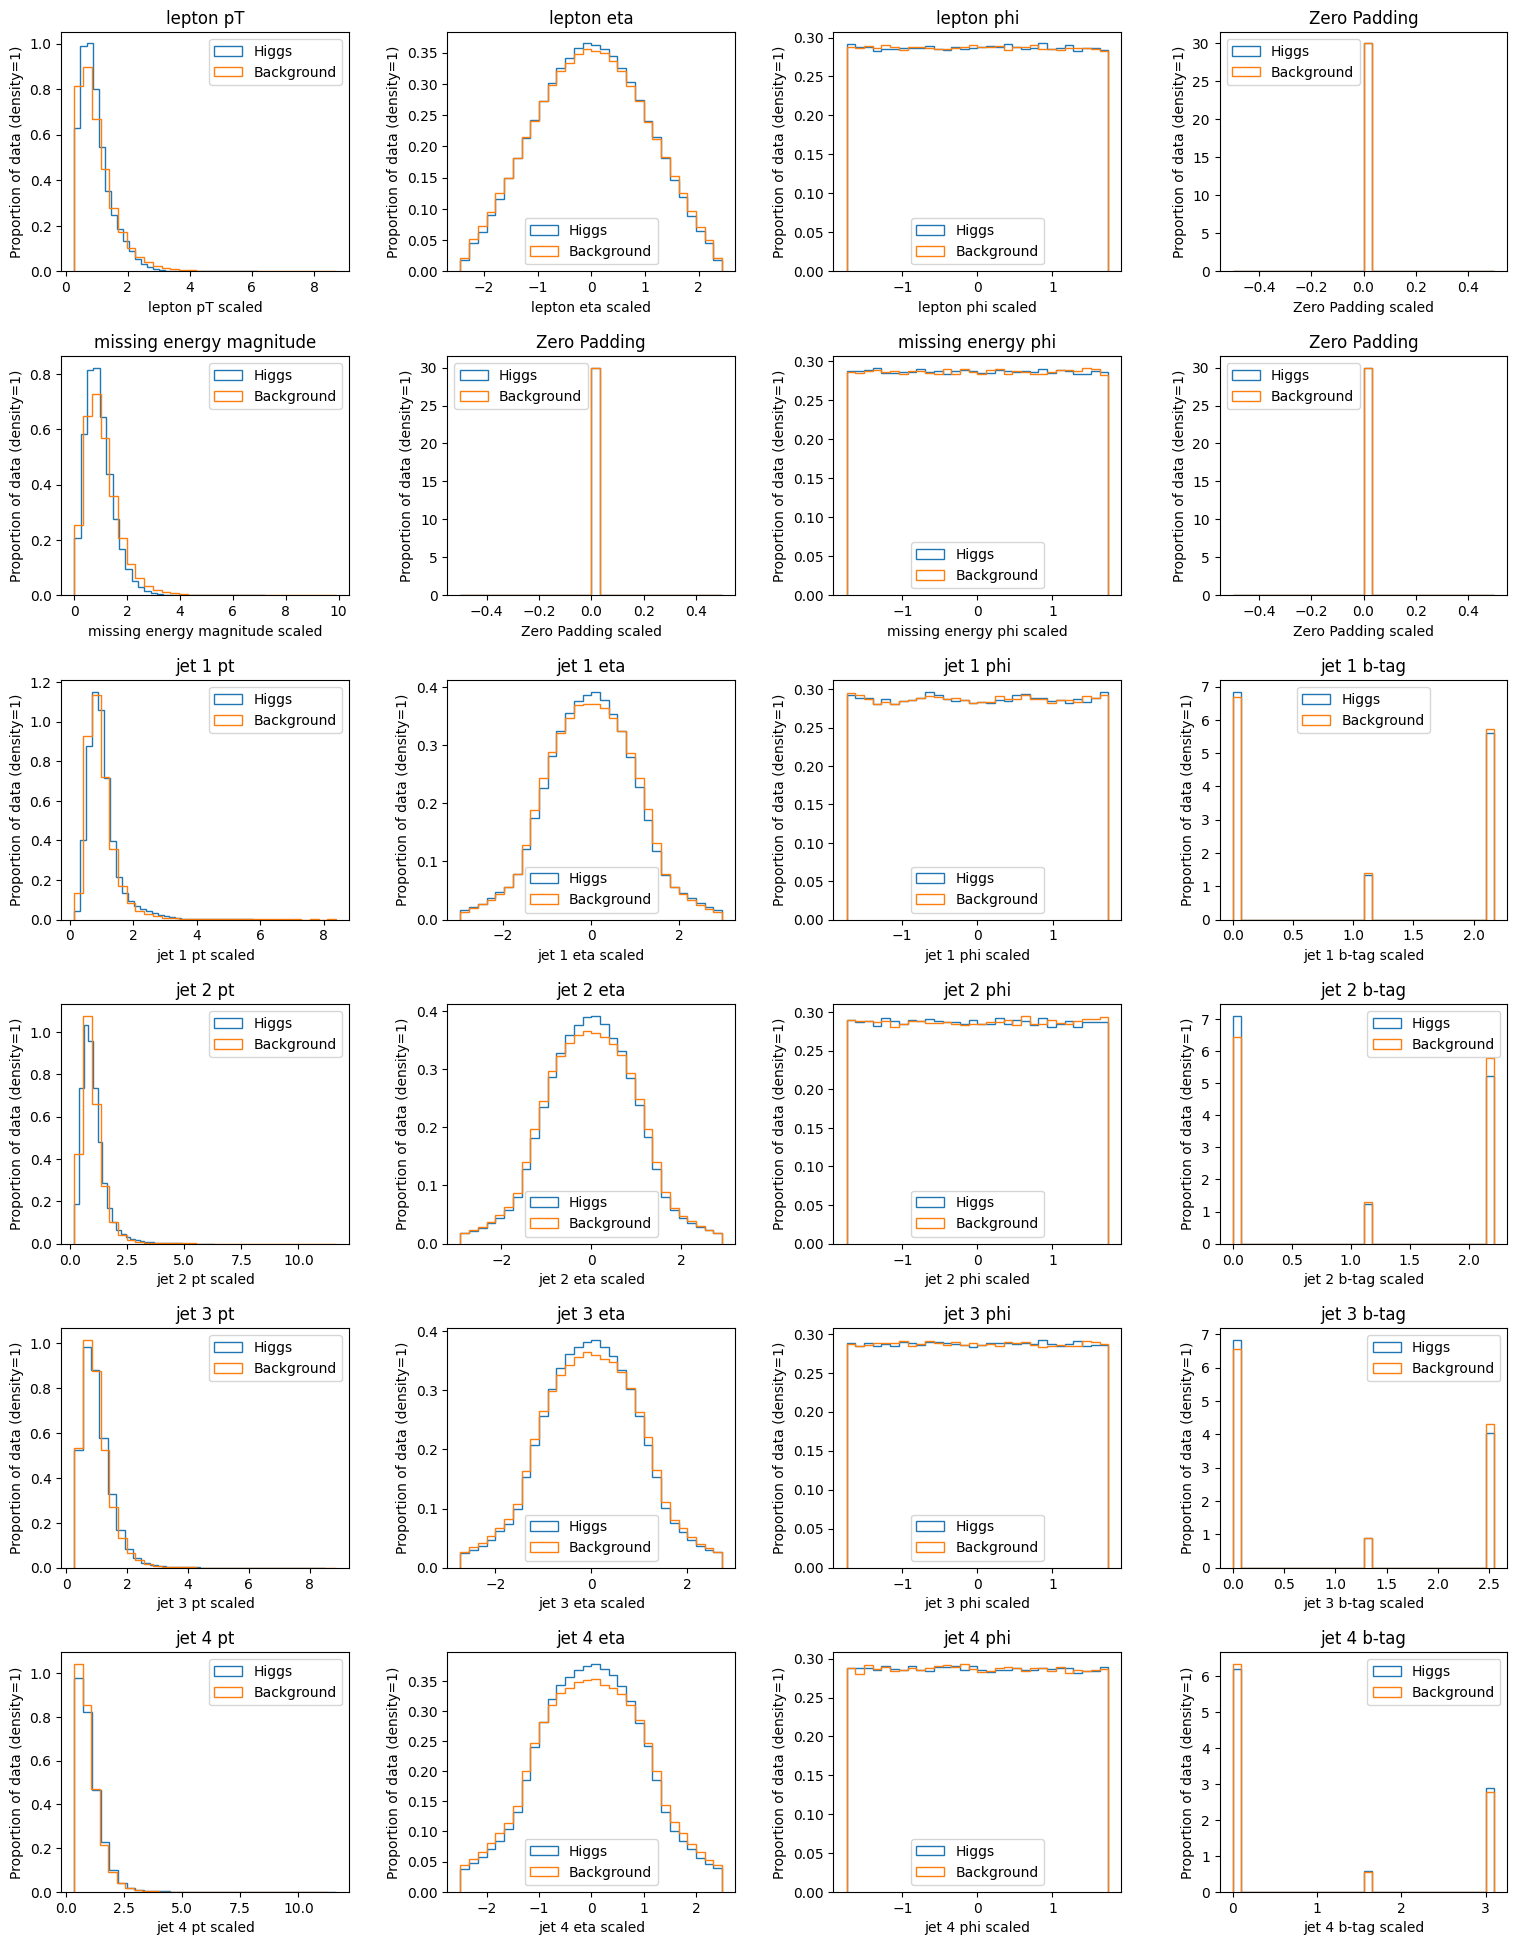

In [8]:
# Visualizing the data
names = ["lepton pT", "lepton eta", "lepton phi", "Zero Padding",
         "missing energy magnitude", "Zero Padding", "missing energy phi", "Zero Padding",
         "jet 1 pt", "jet 1 eta", "jet 1 phi", "jet 1 b-tag",
         "jet 2 pt", "jet 2 eta", "jet 2 phi", "jet 2 b-tag",
         "jet 3 pt", "jet 3 eta", "jet 3 phi", "jet 3 b-tag",
         "jet 4 pt", "jet 4 eta", "jet 4 phi", "jet 4 b-tag"]

fig, axes = plt.subplots(6,4, figsize=(16,20))
fig.tight_layout(pad=4)

X_higgs = X[y==1]
X_nohiggs = X[y==0]
y_higgs = y[y==1]
y_nohiggs = y[y==0]

for i in range(len(axes)):
    for j in range(len(axes[0])):
        axes[i,j].hist(X_higgs[:,i*4+j], histtype='step', stacked=False, density=1, bins=30, label='Higgs')
        axes[i,j].hist(X_nohiggs[:,i*4+j], histtype='step', stacked=False, density=1, bins=30, label='Background')
        axes[i,j].set_title(names[i*4+j])
        axes[i,j].set_xlabel(names[i*4+j] + ' scaled')
        axes[i,j].legend()
        axes[i,j].set_ylabel("Proportion of data (density=1)")
plt.show()

In [9]:
del X
del y

In [10]:
print(len(X_higgs))

529673


In [11]:
print(len(X_nohiggs))

470327


In [12]:
labels_hh = np.ones(len(X_higgs))
labels_tt = np.zeros(len(X_nohiggs))

In [13]:
X_hh_train, X_val1, labels_hh_train, labels_val1 = train_test_split(X_higgs, labels_hh, test_size=0.2, random_state=42)
X_hh_val, X_hh_test, labels_hh_val, labels_hh_test = train_test_split(X_val1, labels_val1, test_size=0.5, random_state=42)

In [14]:
del X_higgs

In [15]:
# Normalize data
x_scaler = StandardScaler()
X_hh_train = x_scaler.fit_transform(X_hh_train)
X_hh_val = x_scaler.transform(X_hh_val)
X_hh_test = x_scaler.transform(X_hh_test)
X_nohiggs = x_scaler.transform(X_nohiggs)

In [16]:
X_tt_train, X_val1, labels_tt_train, labels_val1 = train_test_split(X_nohiggs, labels_tt, test_size=0.2, random_state=42)
X_tt_val, X_tt_test, labels_tt_val, labels_tt_test = train_test_split(X_val1, labels_val1, test_size=0.5, random_state=42)

In [17]:
del X_nohiggs

In [18]:
print(np.shape(X_hh_train), np.shape(X_tt_train))

(423738, 24) (376261, 24)


In [19]:
# Reshape from [N, F] -> [N, P, F] N=event num, F=features, P=particle/jet
X_hh_train = X_hh_train.reshape(X_hh_train.shape[0],6,4)
X_hh_val = X_hh_val.reshape(X_hh_val.shape[0],6,4)
X_hh_test = X_hh_test.reshape(X_hh_test.shape[0],6,4)
X_tt_train = X_tt_train.reshape(X_tt_train.shape[0],6,4)
X_tt_val = X_tt_val.reshape(X_tt_val.shape[0],6,4)
X_tt_test = X_tt_test.reshape(X_tt_test.shape[0],6,4)

phi_limit = np.max((abs(np.max(X_hh_train[:,0,2])), abs(np.min(X_hh_train[:,0,2])))) # Only need one value assuming phi distrubtions are all uniform
lower_pt_limit = [np.min(X_hh_train[:,i,0]) for i in range(6)]

In [20]:
def useful_b_tag(data):
    unique_values = np.unique(data)

    value_to_int = {value: i for i, value in enumerate(unique_values)}

    discretized_data = np.vectorize(value_to_int.__getitem__)(data)

    # initialize an empty array of shape (total_size, 2)
    new_array = np.zeros((len(discretized_data), 2))

    # fill the new array based on your conditions
    for i, val in enumerate(discretized_data):
        if val == 0:
            new_array[i] = [1, 0]
        elif val == 1:
            new_array[i] = [0.5, 0.5]
        else:
            new_array[i] = [0, 1]

    return new_array

In [21]:
def expand_and_append(array):
    array = np.append(array, np.zeros((array.shape[0], array.shape[1], 1)), axis=2)
    return array

In [22]:
# Apply b-tag modification to be a 2-class probability 1 -> [0, 1]; 0 -> [1, 0]; .5 -> [.5, .5]
X_hh_train = expand_and_append(X_hh_train)
X_hh_val = expand_and_append(X_hh_val)
X_hh_test = expand_and_append(X_hh_test)
X_tt_train = expand_and_append(X_tt_train)
X_tt_val = expand_and_append(X_tt_val)
X_tt_test = expand_and_append(X_tt_test)

for i in range(3,len(X_hh_train[0]),5):
    for j in range(6):
        X_hh_train[:,j,i:i+2] = useful_b_tag(X_hh_train[:,j,i])
        X_hh_val[:,j,i:i+2] = useful_b_tag(X_hh_val[:,j,i])
        X_hh_test[:,j,i:i+2] = useful_b_tag(X_hh_test[:,j,i])
        X_tt_train[:,j,i:i+2] = useful_b_tag(X_tt_train[:,j,i])
        X_tt_val[:,j,i:i+2] = useful_b_tag(X_tt_val[:,j,i])
        X_tt_test[:,j,i:i+2] = useful_b_tag(X_tt_test[:,j,i])

In [23]:
print(X_hh_train.shape)

(423738, 6, 5)


In [24]:
# Get weights for soft label focal loss
def get_f_alphas(arr):
    f_alphas = []
    for i in range(arr.shape[1]):
        temp_data = arr[:,i]
        temp_other_data = np.delete(arr, i, 1)
        len_neg = len(temp_data[temp_data == 0])
        pos_data = np.sum(temp_other_data, axis=1)
        len_pos = len(temp_data[temp_data == 1]) - len(temp_other_data[temp_other_data >= 2])/len(temp_other_data)
        f_alphas.append([len_pos/(len_pos+len_neg), len_neg/(len_neg+len_pos)])
    return f_alphas

In [25]:
f_alphas = (get_f_alphas(X_hh_train[:,:,4]))
f_alphas = np.array(f_alphas)

In [26]:
print(f_alphas)

[[0.         1.        ]
 [0.         1.        ]
 [0.45049583 0.54950417]
 [0.42315248 0.57684752]
 [0.37164203 0.62835797]
 [0.3168511  0.6831489 ]]


In [27]:
f_alphas[:,1] *= 1. # Can use a number other than 1 to increase or decrease biasing toward underrepresented b-tag

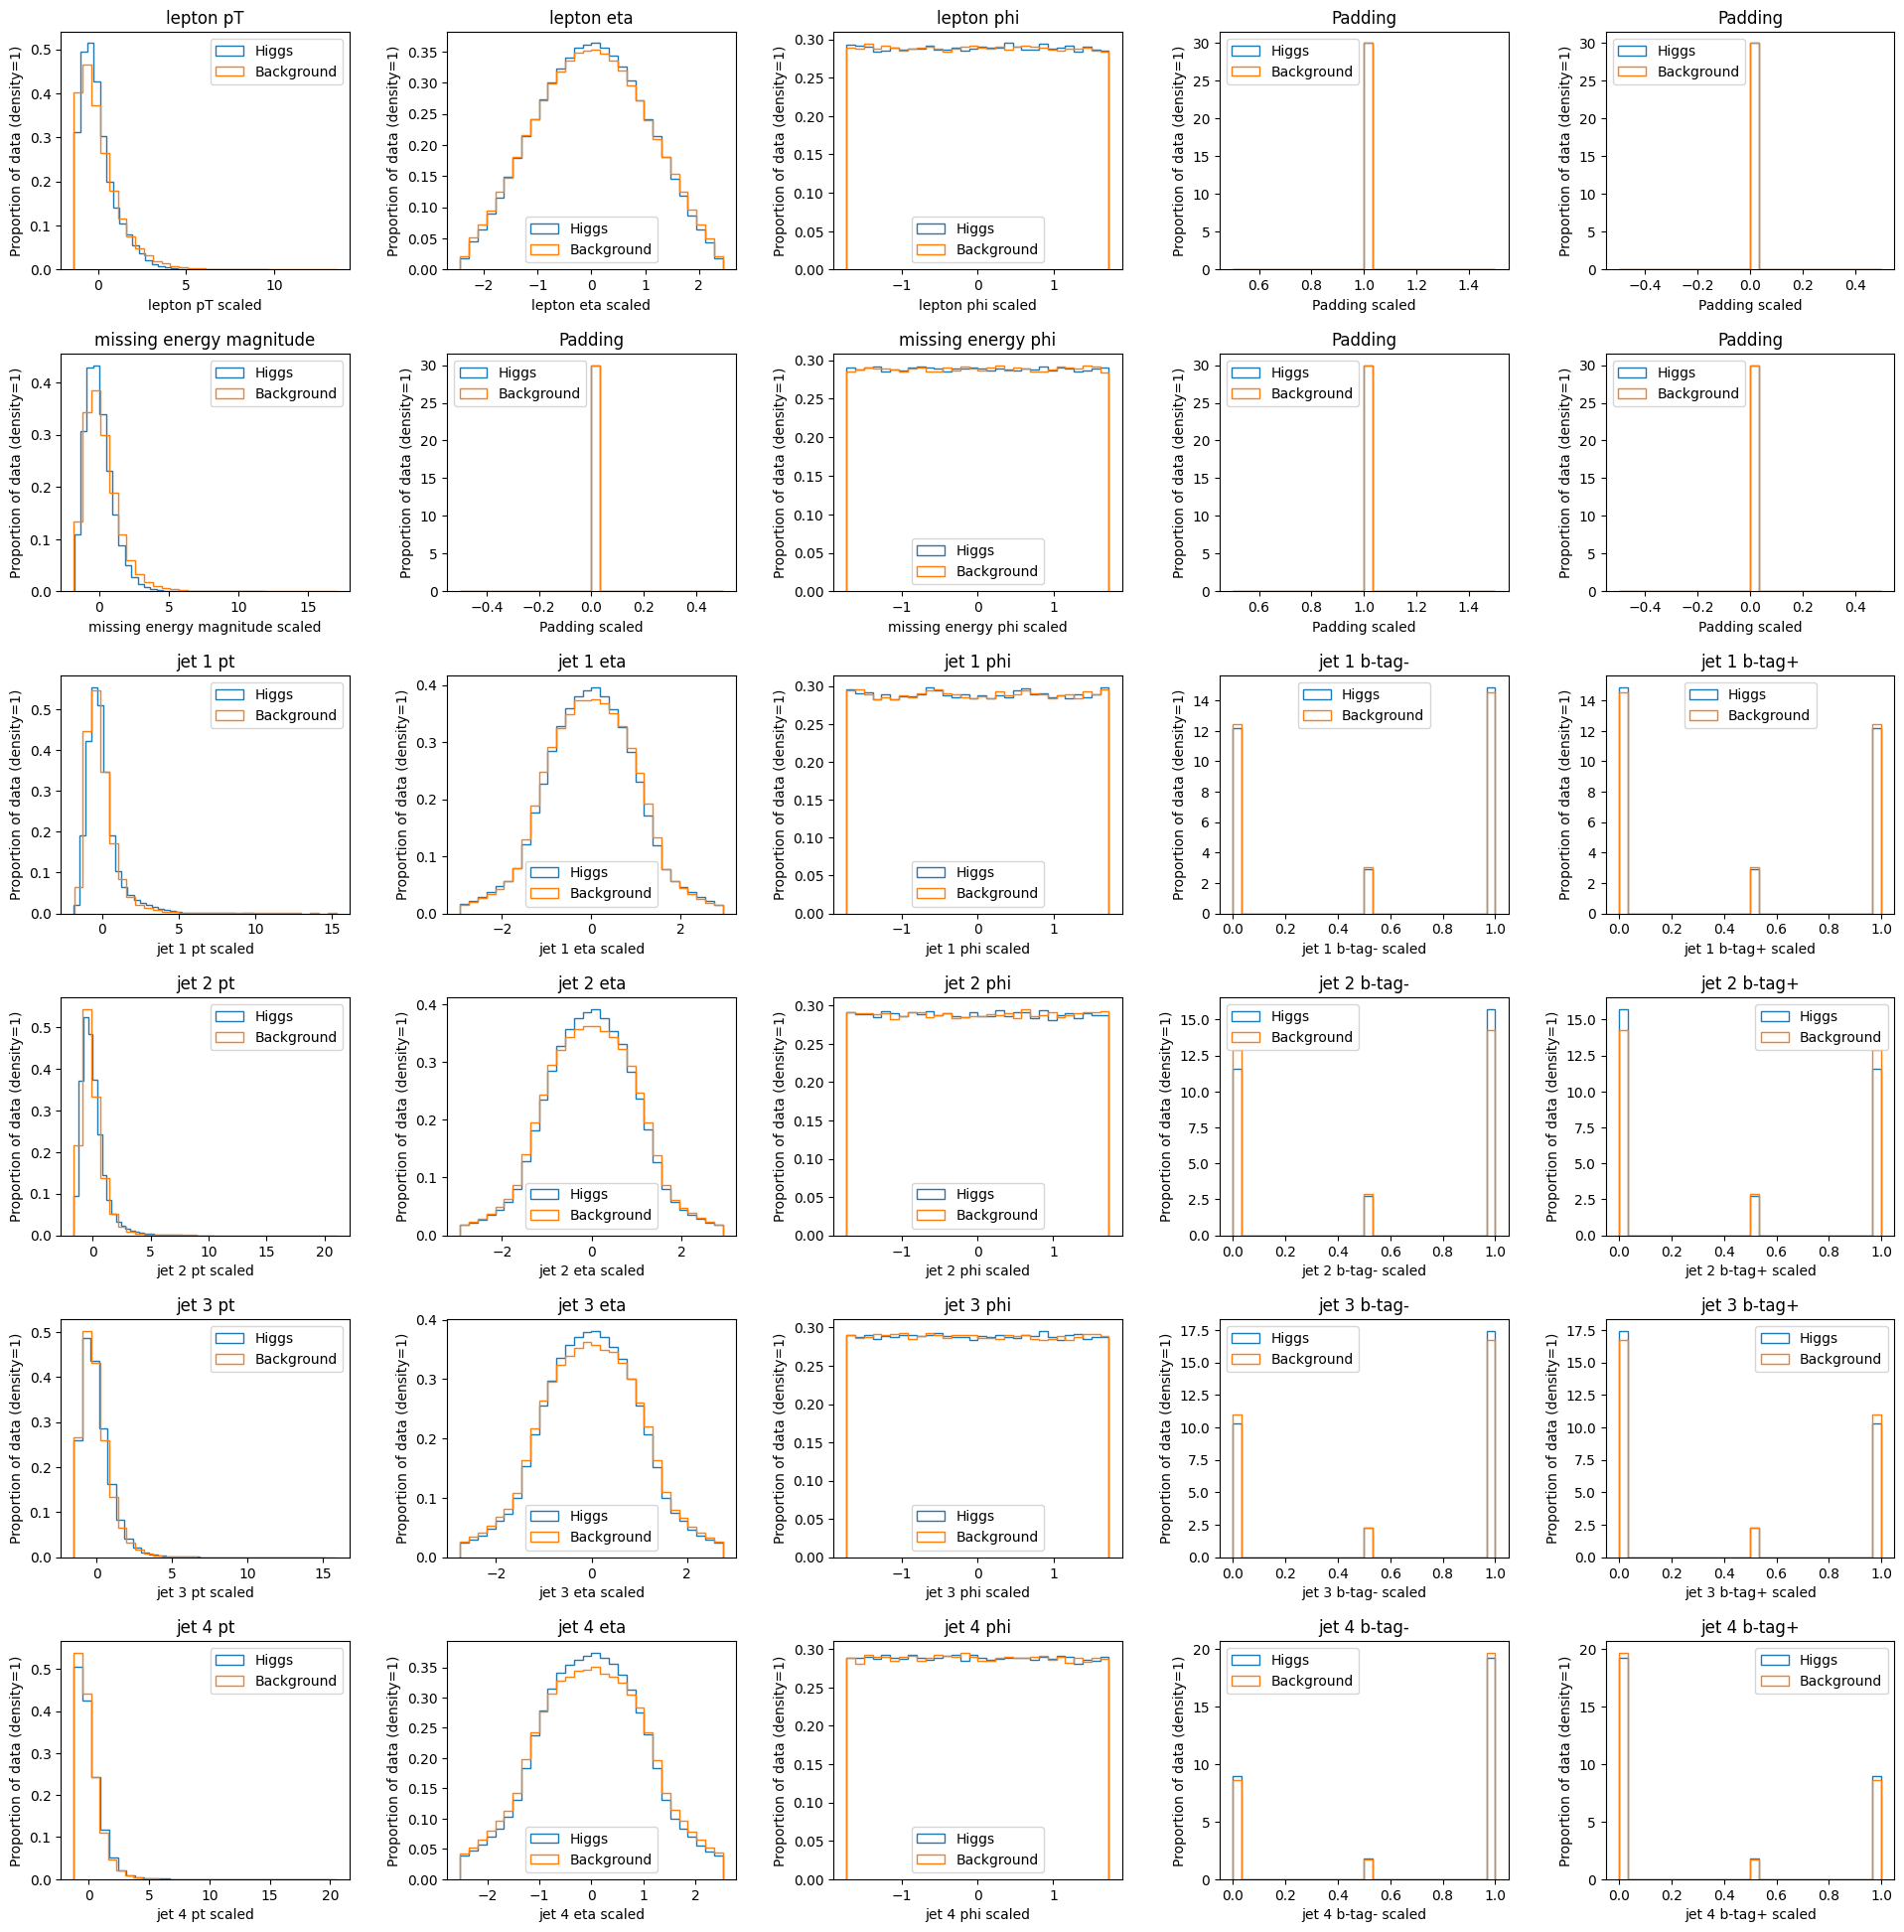

In [28]:
names = ["lepton pT", "lepton eta", "lepton phi", "Padding", "Padding",
         "missing energy magnitude", "Padding", "missing energy phi", "Padding", "Padding",
         "jet 1 pt", "jet 1 eta", "jet 1 phi", "jet 1 b-tag-", "jet 1 b-tag+",
         "jet 2 pt", "jet 2 eta", "jet 2 phi", "jet 2 b-tag-", "jet 2 b-tag+",
         "jet 3 pt", "jet 3 eta", "jet 3 phi", "jet 3 b-tag-", "jet 3 b-tag+",
         "jet 4 pt", "jet 4 eta", "jet 4 phi", "jet 4 b-tag-", "jet 4 b-tag+",]

fig, axes = plt.subplots(6,5, figsize=(20,20))
fig.tight_layout(pad=4)

for i in range(len(axes)):
    for j in range(len(axes[0])):
        axes[i,j].hist(X_hh_train[:,i,j], histtype='step', stacked=False, density=1, bins=30, label='Higgs')
        axes[i,j].hist(X_tt_train[:,i,j], histtype='step', stacked=False, density=1, bins=30, label='Background')
        axes[i,j].set_title(names[i*5+j])
        axes[i,j].set_xlabel(names[i*5+j] + ' scaled')
        axes[i,j].legend()
        axes[i,j].set_ylabel("Proportion of data (density=1)")

In [29]:
X_train = np.append(X_hh_train, X_tt_train, axis=0)
del X_tt_train
X_val = np.append(X_hh_val, X_tt_val, axis=0)
del X_tt_val
X_test = np.append(X_hh_test, X_tt_test, axis=0)
del X_tt_test
labels_train = np.append(labels_hh_train, labels_tt_train, axis=0)
del labels_tt_train
labels_val = np.append(labels_hh_val, labels_tt_val, axis=0)
del labels_tt_val
labels_test = np.append(labels_hh_test, labels_tt_test, axis=0)
del labels_tt_test

In [30]:
# Replace with a saved model name you want to load from
resume = None

In [52]:
if resume is not None:
    # Load a config file from a json
    with open('/content/drive/MyDrive/PMAE/outputs/' + resume, 'r') as f:
        config = json.load(f)
else:
    # Load a config file from a json
    with open('./configs/uci_higgs_config_demo.json', 'r') as f:
        config = json.load(f)

In [32]:
model_name = (
    f'Model_DM{config["d_model"]}_H{config["num_heads"]}_L{config["num_layers"]}'
    f'_F{config["d_ff"]}_DR{config["dropout"]}_BS{config["batch_size"]}_T{config["test_batch_size"]}'
    f'_ANE{config["ae_num_epochs"]}_PNE{config["ae_num_epochs"]}_FNE{config["ae_num_epochs"]}'
    f'_AES{config["ae_epochs_to_saturate"]}_PES{config["pc_epochs_to_saturate"]}'
    f'_FES{config["fc_epochs_to_saturate"]}_IM{config["init_momentum"]}_MM{config["max_momentum"]}'
    f'_TILR{config["tae_init_lr"]}_PCLR{config["pc_init_lr"]}_FCLR{config["fc_init_lr"]}'
    f'_MSL{config["max_seq_len"]}_Mk{config["mask"]}_A{config["alpha"]}_B{config["beta"]}'
    f'_G{config["gamma"]}_D{config["delta"]}_OV{config["output_vars"]}_WD{config["weight_decay"]}'
    f'_MLR{config["min_lr"]}_ALD{config["ae_lr_decay"]}_PLD{config["pc_lr_decay"]}'
    f'_FLD{config["fc_lr_decay"]}_CIF{config["class_input_features"]}_CFD{config["class_ff_dim"]}'
)

In [33]:
# Set device to use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
# Instantiate the dataset and DataLoader
train_data = utils.DataLabelDataset(X_train, labels_train)
train_loader = DataLoader(train_data, batch_size=config["batch_size"], drop_last=True, shuffle=True,
                          pin_memory=True, num_workers=2, pin_memory_device=str(device))
hh_train_data = utils.DataLabelDataset(X_hh_train, labels_hh_train)
hh_train_loader = DataLoader(hh_train_data, batch_size=config["batch_size"], drop_last=True, shuffle=True,
                             pin_memory=True, num_workers=2, pin_memory_device=str(device))
val_data = utils.DataLabelDataset(X_val, labels_val)
val_loader = DataLoader(val_data, batch_size=config["test_batch_size"], shuffle=True)
hh_val_data = utils.DataLabelDataset(X_hh_val, labels_hh_val)
hh_val_loader = DataLoader(hh_val_data, batch_size=config["test_batch_size"], shuffle=True)
test_data = utils.DataLabelDataset(X_test, labels_test)
test_loader = DataLoader(test_data, batch_size=config["test_batch_size"], shuffle=False)
del X_hh_train
del X_hh_val
del labels_hh_train
del labels_hh_val

In [35]:
# Build the autoencoder model
tae = pmae.TransformerAutoencoder(config['d_model'], config['num_heads'], config['num_layers'], config['d_ff'], config['max_seq_len'], config['output_vars'], config['dropout'], device)
# Build classifier
partial_class = classifier.BinaryClassifier(config['class_input_features'], config['class_ff_dim'], config['dropout'])
# Build classifier
full_class = classifier.BinaryClassifier(config['class_input_features'], config['class_ff_dim'], config['dropout'])

c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.activation_relu_or_gelu was not True
  warnings.warn(


In [36]:
# Send the models to gpu if possible
tae = tae.to(device)
partial_class = partial_class.to(device)
full_class = full_class.to(device)

In [37]:
if resume is not None:
    try:
        tae.load_state_dict(torch.load('./saved_models/uci_higgs/TAE_best_' + model_name))
    except:
        print('No saved Autoencoder')
    try:
        partial_class.load_state_dict(torch.load('./saved_models/uci_higgs/Classifier_partial_best_' + model_name))
    except:
        print('No saved Partial Classifier')
    try:
        full_class.load_state_dict(torch.load('./saved_models/uci_higgs/Classifier_full_best_' + model_name))
    except:
        print('No saved Full Classifier')

In [38]:
print(phi_limit)
print(lower_pt_limit)

1.7328222
[np.float32(-1.3673184), np.float32(-1.7830904), np.float32(-1.8183148), np.float32(-1.6098944), np.float32(-1.4880145), np.float32(-1.2340941)]


In [39]:
# Assign the criterion

criterion = utils.custom_loss(phi_limit, config['alpha'], config['beta'], config['gamma'], config['delta'], lower_pt_limit, f_alphas, config['output_vars'])
criterion_2 = nn.BCELoss()

In [45]:
# Build the optimizers
import utils
optimizer = utils.AdamWithDecayAndSaturatingMomentum(
    tae.parameters(), 
    lr=config['tae_init_lr'], 
    betas=(config['init_momentum'], 0.999),
    max_momentum=config['max_momentum'],
    epochs_to_saturate=config['ae_epochs_to_saturate'], 
    batches_per_epoch=len(hh_train_loader), 
    weight_decay=0,
    lr_decay=config['ae_lr_decay'], 
    min_lr=config['min_lr'], 
    resume_epoch=config['ae_resume_epoch']
)

optimizer_2 = utils.SGDWithSaturatingMomentumAndDecay(partial_class.parameters(), lr=config['pc_init_lr'], momentum=config['init_momentum'],
                                                      max_momentum=config['max_momentum'],  epochs_to_saturate=config['pc_epochs_to_saturate'],
                                                      batches_per_epoch=len(train_loader), weight_decay=config['weight_decay'], lr_decay=config['pc_lr_decay'],
                                                      min_lr=config['min_lr'], resume_epoch=config['pc_resume_epoch'])
optimizer_3 = utils.SGDWithSaturatingMomentumAndDecay(full_class.parameters(), lr=config['fc_init_lr'], momentum=config['init_momentum'],
                                                      max_momentum=config['max_momentum'],  epochs_to_saturate=config['fc_epochs_to_saturate'],
                                                      batches_per_epoch=len(train_loader), weight_decay=config['weight_decay'], lr_decay=config['fc_lr_decay'],
                                                      min_lr=config['min_lr'], resume_epoch=config['fc_resume_epoch'])

In [ ]:
print(f"Model name: {model_name}")


Model name: Model_DM100_H4_L2_F400_DR0.03_BS512_T16384_ANE50_PNE50_FNE50_AES50_PES50_FES50_IM0.9_MM0.99_TILR0.02_PCLR0.04_FCLR0.05_MSL6_Mk0_A0.4_B0.5_G1_D2.0_OV4_WD4e-05_MLR1e-05_ALD0.9998_PLD0.99987_FLD0.99987_CIF60_CFD512


In [46]:
import os

# Shorten model_name for saving
safe_model_name = "Model_mtae1"

# Ensure output directories exist
output_dir = os.path.abspath(os.path.join('./outputs', safe_model_name))
os.makedirs(output_dir, exist_ok=True)

save_path = r"D:\ML4SCI_CMS\PMAE_Eric_Reinhardt\saved_models\uci_higgs"
os.makedirs(save_path, exist_ok=True)  # Ensure save path exists

# Train the autoencoder with a shorter model name
val_loss_min = train.train(
    hh_train_loader, hh_val_loader, [tae], device, optimizer, criterion,
    'autoencoder', config['output_vars'], zero_padded=[3,6,8], mask=config['mask'],
    epochs=list(range(config['ae_resume_epoch'], config['ae_num_epochs'])),
    save_path=save_path, model_name=safe_model_name  # Use safe model name
)


Epoch [1/50], Batch [500/827], Loss: 1.5700
Epoch [1/50], Val Loss: 0.8516
Epoch [2/50], Batch [500/827], Loss: 0.8504
Epoch [2/50], Val Loss: 0.8507
Epoch [3/50], Batch [500/827], Loss: 0.8506
Epoch [3/50], Val Loss: 0.8509
Epoch [4/50], Batch [500/827], Loss: 0.8505
Epoch [4/50], Val Loss: 0.8516
Epoch [5/50], Batch [500/827], Loss: 0.8499
Epoch [5/50], Val Loss: 0.8509
Epoch [6/50], Batch [500/827], Loss: 0.8504
Epoch [6/50], Val Loss: 0.8491
Epoch [7/50], Batch [500/827], Loss: 0.8498
Epoch [7/50], Val Loss: 0.8520
Epoch [8/50], Batch [500/827], Loss: 0.8505
Epoch [8/50], Val Loss: 0.8499
Epoch [9/50], Batch [500/827], Loss: 0.8507
Epoch [9/50], Val Loss: 0.8521
Epoch [10/50], Batch [500/827], Loss: 0.8506
Epoch [10/50], Val Loss: 0.8517
Epoch [11/50], Batch [500/827], Loss: 0.8505
Epoch [11/50], Val Loss: 0.8517
Epoch [12/50], Batch [500/827], Loss: 0.8500
Epoch [12/50], Val Loss: 0.8507
Epoch [13/50], Batch [500/827], Loss: 0.8505
Epoch [13/50], Val Loss: 0.8504
Epoch [14/50], Ba

c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.activation_relu_or_gelu was not True
  warnings.warn(


FileNotFoundError: [Errno 2] No such file or directory: './outputs/Model_DM100_H4_L2_F400_DR0.03_BS512_T16384_ANE50_PNE50_FNE50_AES50_PES50_FES50_IM0.9_MM0.99_TILR0.02_PCLR0.04_FCLR0.05_MSL6_Mk0_A0.4_B0.5_G1_D2.0_OV4_WD4e-05_MLR1e-05_ALD0.9998_PLD0.99987_FLD0.99987_CIF60_CFD512.pt/hist2d_di-Higgs_lepton pT.png'

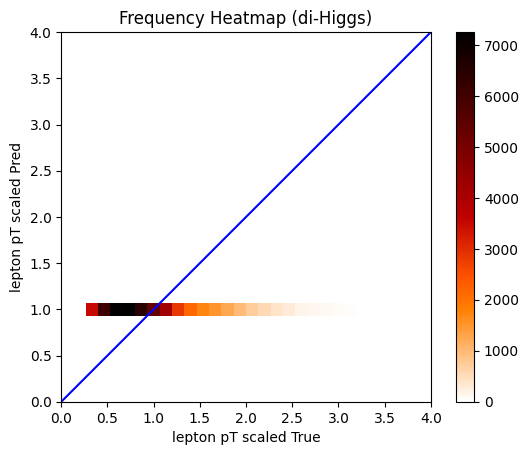

In [56]:
# Build the models and load saved weights
tae = pmae.TransformerAutoencoder(config['d_model'], config['num_heads'], config['num_layers'], config['d_ff'],
                                  config['max_seq_len'], config['output_vars'], config['dropout'], device)
tae.load_state_dict(torch.load(r"D:\ML4SCI_CMS\PMAE_Eric_Reinhardt\saved_models\uci_higgs\TAE_best_Model_mtae1"))
# Send the model to gpu if possible
tae = tae.to(device)
# Test the model and generate some plots
test_and_plot.test(test_loader, config['test_batch_size'], X_test, labels_test, names, [tae], device,
                   config['mask'], x_scaler, config['output_vars'], 'autoencoder', model_name)

# Note: zero-padded values aren't part of the loss function in this demo

In [ ]:
# Build the autoencoder model
tae = pmae.TransformerAutoencoder(config['d_model'], config['num_heads'], config['num_layers'], config['d_ff'],
                                  config['max_seq_len'], config['output_vars'], config['dropout'], device)
tae.load_state_dict(torch.load('./saved_models/uci_higgs/TAE_best_' + model_name))
tae = tae.to(device)
for param in tae.parameters():
    param.requires_grad = False

In [ ]:
# Train a partial-event classifier
val_loss_min = train.train(train_loader, val_loader, [tae, partial_class], device, optimizer_2, criterion_2,
                           'classifier partial', config['output_vars'], zero_padded=[3,6,8], mask=config['mask'],
                           epochs=list(range(config['pc_resume_epoch'], config['pc_num_epochs'])),
                           save_path='./saved_models/uci_higgs', model_name=model_name)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


Epoch [1/50], Batch [500/1562], Loss: 0.6674
Epoch [1/50], Batch [1000/1562], Loss: 0.6469
Epoch [1/50], Batch [1500/1562], Loss: 0.6363
Epoch [1/50], Val Loss: 0.6316
Epoch [2/50], Batch [500/1562], Loss: 0.6282
Epoch [2/50], Batch [1000/1562], Loss: 0.6248
Epoch [2/50], Batch [1500/1562], Loss: 0.6228
Epoch [2/50], Val Loss: 0.6205
Epoch [3/50], Batch [500/1562], Loss: 0.6173
Epoch [3/50], Batch [1000/1562], Loss: 0.6162
Epoch [3/50], Batch [1500/1562], Loss: 0.6166
Epoch [3/50], Val Loss: 0.6100
Epoch [4/50], Batch [500/1562], Loss: 0.6118
Epoch [4/50], Batch [1000/1562], Loss: 0.6113
Epoch [4/50], Batch [1500/1562], Loss: 0.6091
Epoch [4/50], Val Loss: 0.6075
Epoch [5/50], Batch [500/1562], Loss: 0.6076
Epoch [5/50], Batch [1000/1562], Loss: 0.6070
Epoch [5/50], Batch [1500/1562], Loss: 0.6056
Epoch [5/50], Val Loss: 0.6032
Epoch [6/50], Batch [500/1562], Loss: 0.6051
Epoch [6/50], Batch [1000/1562], Loss: 0.6040
Epoch [6/50], Batch [1500/1562], Loss: 0.6036
Epoch [6/50], Val Loss:

In [ ]:
# Train a full event classifier
val_loss_min = train.train(train_loader, val_loader, [tae, full_class], device, optimizer_3, criterion_2,
                           'classifier full', config['output_vars'], zero_padded=[3,6,8], mask=config['mask'],
                           epochs=list(range(config['fc_resume_epoch'], config['fc_num_epochs'])),
                           save_path='./saved_models/uci_higgs', model_name=model_name)

Epoch [1/50], Batch [500/1562], Loss: 0.6551
Epoch [1/50], Batch [1000/1562], Loss: 0.6282
Epoch [1/50], Batch [1500/1562], Loss: 0.6151
Epoch [1/50], Val Loss: 0.6060
Epoch [2/50], Batch [500/1562], Loss: 0.6008
Epoch [2/50], Batch [1000/1562], Loss: 0.5957
Epoch [2/50], Batch [1500/1562], Loss: 0.5890
Epoch [2/50], Val Loss: 0.5827
Epoch [3/50], Batch [500/1562], Loss: 0.5795
Epoch [3/50], Batch [1000/1562], Loss: 0.5779
Epoch [3/50], Batch [1500/1562], Loss: 0.5754
Epoch [3/50], Val Loss: 0.5749
Epoch [4/50], Batch [500/1562], Loss: 0.5686
Epoch [4/50], Batch [1000/1562], Loss: 0.5675
Epoch [4/50], Batch [1500/1562], Loss: 0.5663
Epoch [4/50], Val Loss: 0.5689
Epoch [5/50], Batch [500/1562], Loss: 0.5591
Epoch [5/50], Batch [1000/1562], Loss: 0.5608
Epoch [5/50], Batch [1500/1562], Loss: 0.5588
Epoch [5/50], Val Loss: 0.5666
Epoch [6/50], Batch [500/1562], Loss: 0.5529
Epoch [6/50], Batch [1000/1562], Loss: 0.5527
Epoch [6/50], Batch [1500/1562], Loss: 0.5530
Epoch [6/50], Val Loss:

In [ ]:
# Parse a json config interpretation from a model name string
config = utils.parse_model_name(model_name)

Classification Accuracy (masked  lepton ):  0.5879041209587904


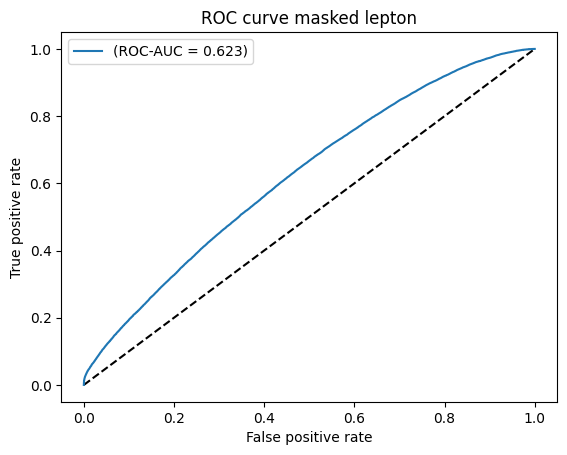

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


Classification Accuracy (masked  missing energy ):  0.6195138048619514


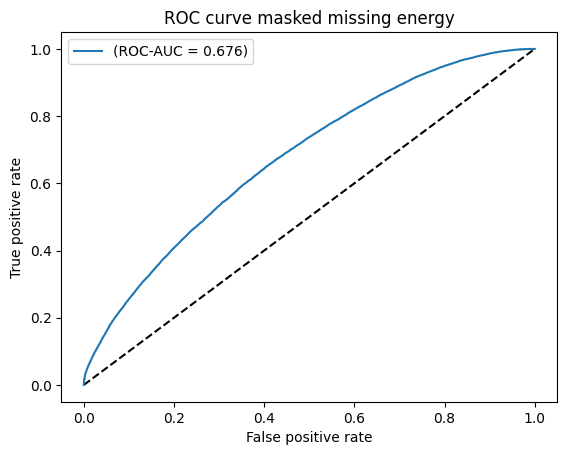

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


Classification Accuracy (masked  jet 1 ):  0.6367936320636793


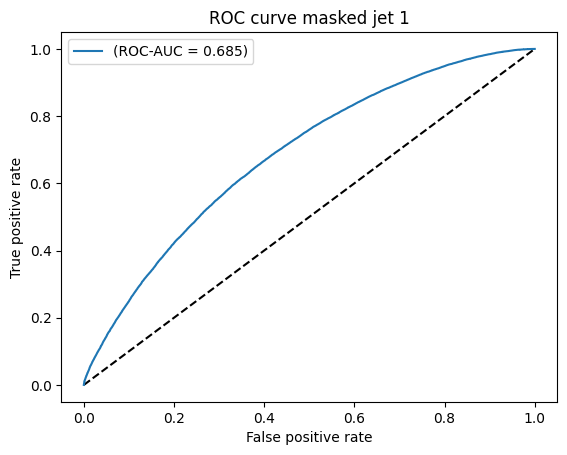

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


Classification Accuracy (masked  jet 2 ):  0.6597234027659723


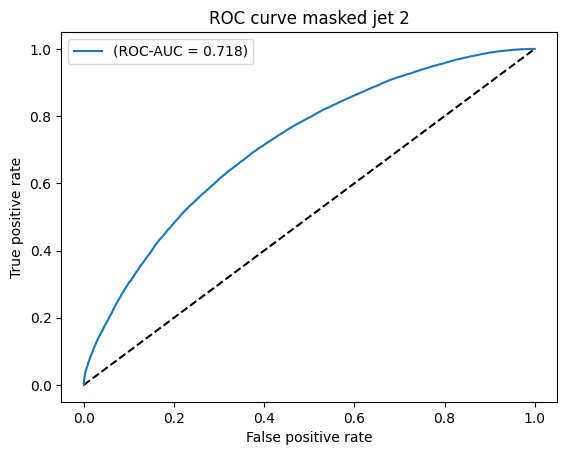

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


Classification Accuracy (masked  jet 3 ):  0.6826031739682603


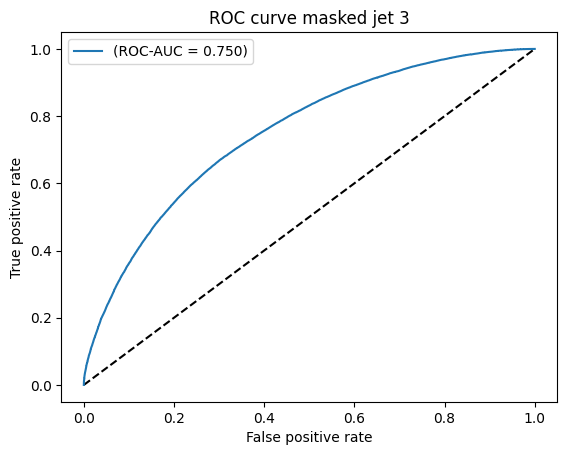

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


Classification Accuracy (masked  jet 4 ):  0.7024429755702443


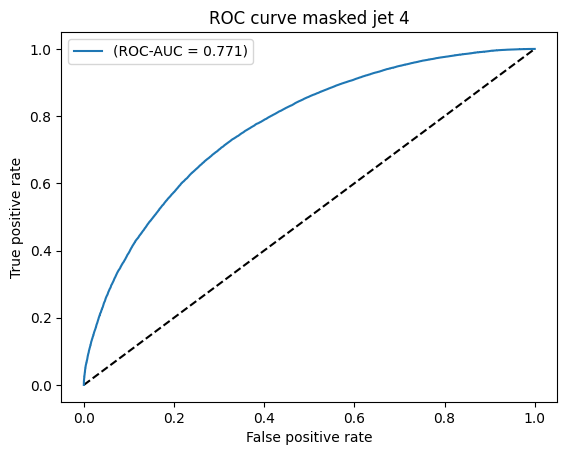

In [ ]:
# Build partial event classifier
partial_class = classifier.BinaryClassifier(config['class_input_features'], config['class_ff_dim'], config['dropout'])
partial_class.load_state_dict(torch.load('./saved_models/uci_higgs/Classifier_partial_best_' + model_name))
# Send the model to gpu if possible
partial_class = partial_class.to(device)
# Test the model and generate some plots
test_and_plot.test(test_loader, config['test_batch_size'], X_test, labels_test, names, [tae, partial_class], device,
                   config['mask'], x_scaler, config['output_vars'], 'partial', model_name)

# Note: zero-padded values aren't part of the loss function in this demo

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


Classification Accuracy (full-information):  0.7141428585714142


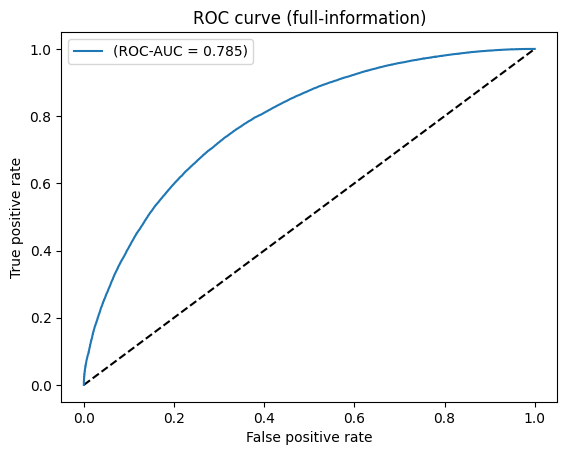

In [ ]:
# Build full event classifier
full_class = classifier.BinaryClassifier(config['class_input_features'], config['class_ff_dim'], config['dropout'])
full_class.load_state_dict(torch.load('./saved_models/uci_higgs/Classifier_full_best_' + model_name))
# Send the model to gpu if possible
full_class = full_class.to(device)
# Test the model and generate some plots
test_and_plot.test(test_loader, config['test_batch_size'], X_test, labels_test, names, [tae, full_class], device,
                   config['mask'], x_scaler, config['output_vars'], 'full', model_name)

# Note: zero-padded values aren't part of the loss function in this demo